In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### 1. Summary Statistics 

In [2]:
insurance = pd.read_csv("data/insurance.csv")
insurance.groupby("region").agg(["mean","std"])


age                   bmi            children            \
                mean        std       mean       std      mean       std   
region                                                                     
northeast  38.831111  13.851183  29.408622  6.094427  1.048889  1.184841   
northwest  39.391129  13.858314  29.241996  5.193813  1.185484  1.186066   
southeast  38.942029  14.150499  33.400942  6.690431  1.010870  1.126487   
southwest  40.000000  14.044081  30.693725  5.702855  1.176471  1.272141   

                charges                
                   mean           std  
region                                 
northeast  13387.630722  11126.065887  
northwest  12609.897092  11329.232371  
southeast  14952.589649  13933.801606  
southwest  12530.708516  11592.095327

In [3]:
##Gender statistics
insurance.groupby(["region","sex"]).agg("count")["age"].rename("Count")

region     sex   
northeast  female    114
           male      111
northwest  female    127
           male      121
southeast  female    130
           male      146
southwest  female    125
           male      130
Name: Count, dtype: int64

In [4]:
##Smoker stats
insurance.groupby(["region","smoker"]).agg("count")["age"].rename("Count")

region     smoker
northeast  no        179
           yes        46
northwest  no        201
           yes        47
southeast  no        202
           yes        74
southwest  no        209
           yes        46
Name: Count, dtype: int64

### 2. Characteristics 

This population has clients in ages ranging from 18 to 64, with highest number of insurers between the ages 18-19 (\~50 people per age), and uniformly distributed number of clients per all other ages (\~20 people). Based on summary statistics, there is no clear difference in center/spread of attributes grouped by region.  Approximately 57% of population have on average of 2 children insured, and the remaining 43% do not have children insured.

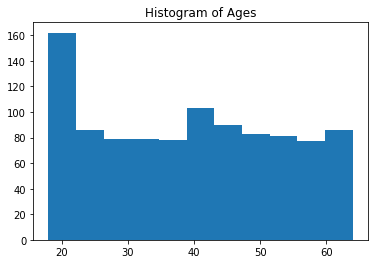

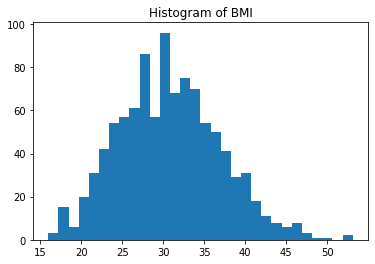

,count
age,
18,49
19,50
20,20
21,21
22,22


In [5]:
plt.hist(insurance["age"], bins="auto")
plt.title("Histogram of Ages")
plt.show()
plt.hist(insurance["bmi"], bins=30)
plt.title("Histogram of BMI")
plt.show()

pd.DataFrame(insurance.groupby("age").agg("count").head()["sex"].rename("count"))

In [6]:
##checking children stats
insurance["children"].unique()
round(sum(insurance["children"] != 0)/len(insurance),2)

0.57

In [7]:
##average number of kids insured
np.mean(insurance[insurance["children"] != 0]["children"])

1.9220103986135182

### 3. Gender/Age
Is female age different from male age?


$H_0: \mu_{female} = \mu_{male}$  
$H_1: \mu_{female} \neq \mu_{male}$  

With the assumption of identical variances of age grouped by sex, we conduct a t-test with p-value of 0.11.  At significance level $\alpha = 0.05$, we accept the null hypothesis, which means there's not enough evidence to conclude a difference in ages of insurers for different genders.

In [8]:
##age statistics
pd.DataFrame(insurance.groupby(["sex"]).agg(["mean","std","count"])["age"])

,mean,std,count
sex,,,
female,40.004032,13.91707,496
male,38.606299,14.00361,508


In [9]:
female = insurance[insurance["sex"]=="female"]["age"]
male = insurance[insurance["sex"]=="male"]["age"]
#assumption: populations of female/male insurers have identical variances
stats.ttest_ind(female,male)

Ttest_indResult(statistic=1.5860463168350691, pvalue=0.11304431459154292)

### 4.  Smoking rate 
Is there a difference in smoking rates between those who have kids and those who do not?

$H_0: \mu_{kids} = \mu_{no\_kids}$  
$H_1: \mu_{kids} \neq \mu_{no\_kids}$  

Based on the t-test results, there is no significant difference in proportion of smokers grouped on whether or not they have children. P-value is 0.825, At significance level $\alpha = 0.05$, we accept the null hypothesis, which means there's not enough evidence to conclude a difference in smoking rates between those who have kids and those who do not.

In [10]:
insurance["kid"] = (insurance["children"] > 0).astype("int")
insurance["smoker"] = insurance["smoker"].map({'yes': 1, 'no': 0})
insurance.groupby("kid").agg(["mean","std"])["smoker"]


,mean,std
kid,,
0,0.215457,0.411621
1,0.209705,0.407452


In [11]:

kids = insurance[insurance["kid"]== 1]["smoker"]
no_kids = insurance[insurance["kid"]== 0]["smoker"]

In [12]:
stats.ttest_ind(kids, no_kids)

Ttest_indResult(statistic=-0.2201579269704336, pvalue=0.8257930078763985)

### 5.  collinearity

Based on correlation coefficients, the collinearity is highest between smoker and insurance charges.

In [13]:
insurance["sex"] = insurance["sex"].map({"male":1, "female":0})

In [14]:
data = insurance.iloc[:,:-1]
data.corr()

,age,sex,bmi,children,smoker,charges
age,1.000000,-0.050042,0.122592,0.039342,-0.030918,0.300724
sex,-0.050042,1.000000,0.057649,0.031525,0.083945,0.062405
bmi,0.122592,0.057649,1.000000,0.003464,-0.005651,0.191917
children,0.039342,0.031525,0.003464,1.000000,-0.014863,0.053132
smoker,-0.030918,0.083945,-0.005651,-0.014863,1.000000,0.786831
charges,0.300724,0.062405,0.191917,0.053132,0.786831,1.000000


### 6. Effects

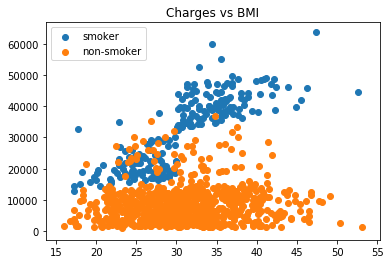

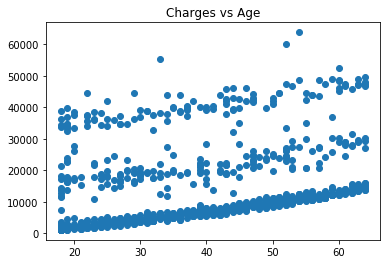

In [15]:
###Visualization of linearity trends

smoke = insurance[insurance["smoker"] == 1]
n_smoke = insurance[insurance["smoker"] == 0]

plt.scatter(smoke["bmi"], smoke["charges"])
plt.scatter(n_smoke["bmi"], n_smoke["charges"])
plt.title("Charges vs BMI")
plt.legend(["smoker", "non-smoker"])
plt.show()
##smoke bmi interaction term

plt.scatter(insurance["age"], insurance["charges"])
plt.title("Charges vs Age")
plt.show()

In [16]:
insurance["interact"] = insurance["smoker"]*insurance["bmi"]
X = np.array(insurance[["sex","bmi","smoker","age","interact"]])
y = np.array(list(insurance["charges"]))

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=125)

alphas = np.arange(0.1, 1, 0.1)  
#parameter tuning
clf = linear_model.RidgeCV(alphas)
clf.fit(X_train,y_train)
#Scores
print("Training: ", clf.score(X_train,y_train))
print("Test: ", clf.score(X_test, y_test))

#coefficients
#[round(v, 4) for v in clf.coef_]

Training:  0.8328752774280138
Test:  0.8611344228042562


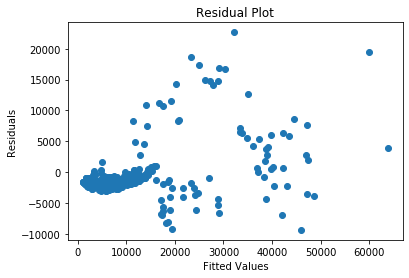

In [18]:
##Residual plot
plt.scatter(y_test, y_test - clf.predict(X_test))
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Model and Conclusions

#### Model: Ridge Regression with interaction term
$\hat{y}$ = predicted charges  
$\hat{y} = -531.4497(male) -0.73(bmi) -19568.3256(smoker)+ 258.7993(age)+ 1409.25(smoker*bmi)$


In [19]:

print("Predicted increase in charge for a smoker with bmi of 26.6 (Average BMI in the U.S.): $", round(26.6*1409.25 - 19568.3256,2))

Predicted increase in charge for a smoker with bmi of 26.6 (Average BMI in the U.S.): $ 17917.72


Based on the model:
- Being a male reduces charges by approximately $500
- Being a smoker affects medical cost by 1409.25(bmi)-19568.3256, based on average bmi (26.6) in the United States, being a smoker would increase charges by approximately \$17917.72.  
- The effect of each additional year on medical cost is approximately \$258.8 per year increase

Assumptions made for this model are:  
- e \~ $N(0, \sigma^2)$
- linearity
- Independence of observations

From the residual plot we can see residuals are fairly random and follow constant variance. Linearity assumptions was checked with correlation coefficients and plots above. 

### 7. Probability model 

We can use a logistic regression model trained on features from the data that we have.  

With weights we obtain from the regression we can then plug values into the equation below to get a probability.

$p_i = \frac{exp(\beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip})}{1 + exp(\beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip})}$  

To evaluate the effectiveness of the model, we can use cross-validation with varying number of features to see where accuracy for both training and test data is maximized.  

We can decide on a cutoff based on the true labels (> 50k or not) of our data and find a cutoff which maximizes classification accuracy in both groups (> 50k or not). Another way to decide on threshold would be to balance profit and risk tradeoff.

If we were to pick a somewhat arbitrary X, I think X should be at 0.50 since we want to minimize the number of false negatives in this case and so 0.5 is a safe probability cutoff to work with as it's at the half-way point. 

### Section II: Checking Conversion Rates

In [20]:
from datetime import datetime

conversion_rates = pd.read_csv("data/conversion_rates.csv")
conversion_rates.groupby("came_from").agg("mean")

conversion_rates["date"] = [datetime.strptime(date,"%Y-%m-%d") for date in conversion_rates["date"]]
after = conversion_rates["date"] > datetime.strptime("2018-09-05","%Y-%m-%d")

conversion_rates["after"] = after

In [21]:
A = conversion_rates[conversion_rates["came_from"]=="Insurance Site A"]
B = conversion_rates[conversion_rates["came_from"]=="Insurance Site B"]
C = conversion_rates[conversion_rates["came_from"]=="Insurance Site C"]
google = conversion_rates[conversion_rates["came_from"]=="Google Search"]


X_A = np.array(A.iloc[:,[1,2,3,6]])
y_A = np.array(A["reached_end"])

X_B = np.array(B.iloc[:,[1,2,3,6]])
y_B = np.array(B["reached_end"])

X_C = np.array(C.iloc[:,[1,2,3,6]])
y_C = np.array(C["reached_end"])

X_Google = np.array(google.iloc[:,[1,2,3,6]])
y_Google = np.array(google["reached_end"])


In [22]:
modA = linear_model.LogisticRegression(random_state=0, solver='lbfgs').fit(X_A, y_A)
print("Model A", modA.coef_)

modB = linear_model.LogisticRegression(random_state=0, solver='lbfgs').fit(X_B, y_B)
print("Model B", modB.coef_)

modC = linear_model.LogisticRegression(random_state=0, solver='lbfgs').fit(X_C, y_C)
print("Model C", modC.coef_)

modGoogle = linear_model.LogisticRegression(random_state=0, solver='lbfgs').fit(X_Google, y_Google)
print("Model Google",modGoogle.coef_)


Model A [[-0.39234512  0.06835397  0.15303019 -0.01697152]]
Model B [[ 0.16998791 -0.05672903  0.23041274 -0.05380087]]
Model C [[ 0.18571578 -0.01778265 -0.47148571  0.60576608]]
Model Google [[ 0.23144929  0.0123093  -0.42630685  0.8191712 ]]


I decided to fit logistic models for each type of site that the data came from (A,B,C, and Google), and then use attributes: male, age, has_insurance, and after (implementation of the feature) to train the models.  From the coefficients ouputted above, it looks like in general the product change improved conversion rates if searches came from site C or Google Search, but not for Site A and B. I think we can work on further developing features to appeal to clients coming from Site A and B more.

### Section III: Visualizing Data 

In [23]:
names_id_age = pd.read_csv("data/names_id_age.csv")
lead_sale_stats = pd.read_csv("data/lead_sale_stats.csv").dropna()

lead_type, lead_id = [], []

for v in lead_sale_stats["lead_id"]:
    typ, id_ = sorted(v.split("_"), key=len) 
    lead_type.append(typ)
    lead_id.append(int(id_))

lead_sale_stats["lead_id"] = lead_id
lead_sale_stats["lead_type"] = lead_type

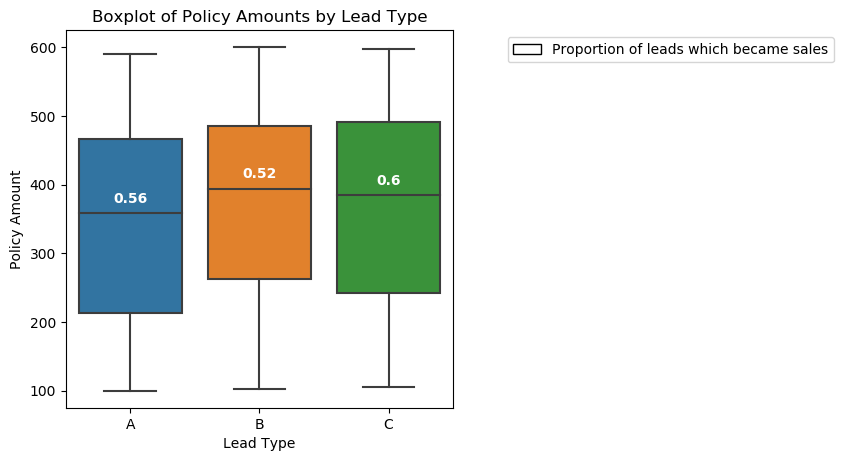

In [24]:
import seaborn as sns
import matplotlib.patches as mpatches

data = pd.merge(lead_sale_stats, names_id_age, left_on='lead_id',right_on="lead_id", how='left')
data = data[["lead_id", "lead_type_y", "bought_policy", "policy_amount"]]
grped = data.groupby("lead_type_y").agg("mean")
proportions = [round(v,2) for v in grped["bought_policy"]]
data_purchased = data[data["bought_policy"]==1]
vertical_offsets = [373, 410,400]

plt.figure(figsize=(5,5), dpi=100)
white_patch = mpatches.Patch(label='Proportion of leads which became sales',facecolor='white', edgecolor='black')
box_plot = sns.boxplot(x="lead_type_y", y="policy_amount", data=data_purchased, order=["A", "B", "C"])
box_plot.set_title("Boxplot of Policy Amounts by Lead Type")
box_plot.set_ylabel("Policy Amount")
box_plot.set_xlabel("Lead Type")
box_plot.legend(bbox_to_anchor=(2, 1),loc="upper right", handles=[white_patch])

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, vertical_offsets[xtick], proportions[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')


Based on the proportion of leads which became sales, it doesn't seem like lead indicators are very accurate -- proportion of buyers are same regardless of their indicated likelihood to purchase. The spread of policy amount spent per lead type are also very similar across groups. To help growth we should improve the accuracy of indicators and focus on targetting groups which were indicated with the lowest intent to buy.